# multiscale model fitting for Toy2

### start with initalizing many things

In [63]:
# imports
import os
# import sys
import torch
# import pickle
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
# import time
import math

# module_path = os.path.abspath(os.path.join('../src/'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
    
# import torch_cae_multilevel_V4 as net
import ResNet as tnet
# import utils

In [7]:
# paths
data_dir = './data/toy2'
model_dir = './model/toy2'
result_dir = './result/toy2'

#load data
train_data = torch.tensor(np.load(os.path.join(data_dir, 'train_data.npy')))
val_data = torch.tensor(np.load(os.path.join(data_dir, 'val_data.npy')))
test_data = torch.tensor(np.load(os.path.join(data_dir, 'test_data.npy')))

data_of_sizes = {}
current_size = 2
# unresolved_dict = {}
# data_levels_dict = {}


In [12]:
#functions, will move these to a utils file eventually 
#====================================================================================
# def data_of_size(data,size):
#     """
#     Takes averages to shrink size of data
#     Takes data of size (n_points, dim, dim) and shrinks to size (n_points, size, size)
#     takes averages to shrink
#     """
#     return decrease_to_size(torch.tensor(data).unsqueeze(1), size)[:,0,:,:]
#====================================================================================


def isPowerOfTwo(n):
    """
    checks if n is a power of two
    
    input: n, int
    
    output: boolean
    """
    return (np.ceil(np.log2(n)) == np.floor(np.log2(n)));
#====================================================================================
def shrink(data, low_dim):
    '''
    Shrinks data to certain size; either averages or takes endpoints
    
    inputs:
        data: array of size (n_points, n_timesteps, dim, dim) that will shrink
        low_dim: int, size to shrink to, low_dim must be less than or equal to dim
        
    output:
        data: array of size (n_points, n_timesteps, low_dim, low_dim)
    '''
    
    #check inputs
    assert len(data.shape) == 4
    n_points, n_timesteps, dim, _ = data.shape
    assert dim >= low_dim
    assert isPowerOfTwo(low_dim)
    
    if dim == low_dim: #same size, no change
        return data
    
    while(dim > low_dim):
        #shrink by 1 level until same size
        data = apply_local_op(data.float(), 'cpu', ave=average)
        current_size = data.shape[-1]
        
    return data
#====================================================================================
def ave_one_level(data):
    '''
    takes averages to shrink data 1 level
    
    inputs:
        data: tensor of size (n_points, n_timesteps, dim, dim) that will shrink
        
    output:
        processed data: tensor of size (n_points, n_timesteps, dim/2, dim/2)
    '''
    device = 'cpu'
    if not torch.is_tensor(data): #needs to be a tensor
        data = torch.tensor(data)
        
    assert len(data.shape) == 4
#     if data.shape != 4:
#         print("data.shape = ", data.shape)
#         print("data.shape should be of length 4")
    n_points, n_timesteps, dim, _ = data.shape
    
    #dim needs to be even 
    assert dim % 2 == 0
    
    data_right_size = torch.flatten(data, 0,1).unsqueeze(1).float()
    
#     n = min(in_channels, out_channels)
    op = torch.nn.Conv2d(1, 1, 2, stride=2, padding=0).to(device)
   
    op.weight.data = torch.zeros(op.weight.data.size()).to(device)
    op.bias.data = torch.zeros(op.bias.data.size()).to(device)
    op.weight.data[0,0, :, :] = torch.ones(op.weight.data[0,0, :, :].size()).to(device) / 4

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False
        
    print("Transforming")
        
    shrunk = op(data_right_size)
    
    print("reshape to print")
    
    return shrunk.squeeze(1).reshape((n_points, n_timesteps, dim//2, dim//2))



In [13]:
print(train_data.shape)
processed = ave_one_level(train_data)
print(processed.shape)

torch.Size([100, 500, 128, 128])
Transforming
reshape to print
torch.Size([100, 500, 64, 64])


In [21]:

#make a dictionary with train data of every size 128->1
#====================================================================================

def make_dict_all_sizes(data):
    """
    Makes a dictionary of data at every refinedment size from current->1
    
    inputs:
        data: tensor(or array) of size (n_points, n_timesteps, dim, dim)
        
    outputs: 
        dic: dictionary of tensors. Keys are dim size, tensors are size (n_points, n_timesteps, dim, dim)
    
    """
    
    n_points, n_timesteps, dim, _ = data.shape
    
    if not torch.is_tensor(data): #needs to be a tensor
        data = torch.tensor(data)
        
    assert isPowerOfTwo(dim)
        
    dic = {str(dim): data}
    
    for i in range(int(np.log2(dim))):
        #decrease
        print("i = ", i)
        data = ave_one_level(data)
        dic[str(data.shape[-1])] = data
    
    print(dic.keys())
    
    return dic
#====================================================================================


In [29]:
train_dict = make_dict_all_sizes(train_data)
val_dict = make_dict_all_sizes(val_data)

i =  0
Transforming
reshape to print
i =  1
Transforming
reshape to print
i =  2
Transforming
reshape to print
i =  3
Transforming
reshape to print
i =  4
Transforming
reshape to print
i =  5
Transforming
reshape to print
i =  6
Transforming
reshape to print
<built-in method keys of dict object at 0x000001233BD84540>


In [51]:
#====================================================================================
def train_one_timestep(step_size, train_data, val_data, test_data, current_size, 
                       dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = True, 
                       lr = 1e-3, max_epochs = 10000, batch_size = 50,threshold = 1e-4, model_dir = './models/toy2'):

    """
    fits or loads model at 1 timestep
    
    inputs:
        step_size: int 
        train_data: tensor size (n_points, n_timesteps, dim**2) 
        val_data:tensor size (n_val_points, n_timesteps, dim**2) 
        test_data:tensor size (n_test_points, n_timesteps, dim**2) 
        current_size: int, only used in file naming
        dt = 1: float
        n_forward = 5: int, number of steps to consider during training
        noise=0: float, level of noise, (right now just used in file naming)
        make_new = False: boolean, whether or not to make a new model if old already exists
        dont_train = True: boolean, whether or not to train more if model loaded
        lr = 1e-3: float, learning rate
        max_epochs = 10000: int 
        batch_size = 50: int
        threshold=1e-4: float, stop training when validation gets below threshold
         
    
    outputs:
        model_time: ResNet object of trained model. Also saved
    """
    model_name = 'model_L{}_D{}_noise{}.pt'.format(current_size,step_size, noise)
    model_path_this = os.path.join(model_dir, model_name)
    
    n_points, n_timesteps, total_dim = train_data.shape
    arch = [total_dim, 128, 128, 128, total_dim] 
    
    try: #if we already have a model saved
        if make_new:
            print("Making a new model. Old one deleted. model {}".format(model_name))
            assert False
        model_time = torch.load(model_path_this)
        print("model loaded")
        print("don't train = ", dont_train)
        if dont_train: #just load model, no training
            return model_time
    except:
        print('create model {} ...'.format(model_name))
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    dataset = tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
    
    
    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=model_path_this,threshold= threshold)
    
    return model_time
#====================================================================================

def find_best_timestep(train_data, val_data, test_data, current_size, start_k = 0, largest_k = 7, 
                       dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = True,
                       lr = 1e-3, max_epochs = 10000, batch_size = 50,threshold = 1e-4, 
                       criterion = torch.nn.MSELoss(reduction='none'), model_dir = "./models/toy2",):
    """
    Trains models with different timestep sizes and finds lowest error
    
    inputs:
     n_forward = 5, noise=0, make_new = False, dont_train = False):
    
        train_data: tensor size (n_points, n_timesteps, dim, dim) 
        val_data:tensor size (n_val_points, n_timesteps, dim, dim) 
        test_data:tensor size (n_test_points, n_timesteps, dim, dim) 
        current_size: int, only used in file naming
        start_k = 0: int, smallest timestep will be 2**start_k
        largest_k = 7:int, largest timestep will be 2**largest_k
        dt = 1: float
        n_forward = 5: int, number of steps to consider during training
        noise=0: float, level of noise, (right now just used in file naming)
        make_new = False: boolean, whether or not to make a new model if old already exists
        dont_train = False: boolean, whether or not to train more if model loaded
        lr = 1e-3: float, learning rate
        max_epochs = 10000: int 
        batch_size = 50: int
        threshold=1e-4: float
        criterion = torch.nn.MSELoss(reduction='none'))
         
         
    outputs:
        models: list of ResNet models
        step_sizes: list of ints for the steps_sizes of models 
        mse_list: list of floats, mse of models 
        idx_lowest: int, index value with lowest mse
         
    """
    models = list()
    step_sizes = list()
    mse_lowest = 1e10 #big number
    mse_list = list()
    mse_less = 0
    idx_lowest = -1
    
    #make data flat to right dim (n_points, n_timesteps, dim**2)
    train_data = torch.flatten(train_data, 2,3)
    val_data = torch.flatten(val_data, 2,3)
    test_data = torch.flatten(test_data, 2,3)
    
    n_points, n_timesteps, total_dim = train_data.shape
    
    for k in range(start_k, largest_k):
        step_size = 2**k
        step_sizes.append(step_size)
        model_time = train_one_timestep(step_size, train_data, val_data, test_data, current_size, 
                                        make_new = make_new, dont_train = dont_train)
        models.append(model_time)
    
        #find error
        
        y_preds = model_time.uni_scale_forecast(val_data[:, 0, :].float(), n_steps=n_timesteps-1)
        mse_all = criterion(val_data[:, 1:, :].float(), y_preds).mean(-1)

        mean = mse_all.mean(0).detach().numpy()
#         print(mean.shape)
        mse_less = mean.mean()
        mse_list.append(mse_less)

        print("mse_lowest = ", mse_lowest)
        print("mse_less= ", mse_less)
        
        if (mse_less< mse_lowest) or (math.isnan(mse_lowest)) or (math.isnan(mse_less)):
            mse_lowest = mse_less
            idx_lowest = k

    return models, step_sizes, mse_list, idx_lowest
#====================================================================================


In [54]:
current_size = 1
models, step_sizes, mse_list, idx_lowest = find_best_timestep(train_dict[str(current_size)], 
                                                              val_dict[str(current_size)], 
                                                              val_dict[str(current_size)], current_size,model_dir=model_dir)

model loaded
don't train =  True
mse_lowest =  10000000000.0
mse_less=  nan
create model model_L1_D2_noise0.pt ...
self.n_dim=  1
dataset.n_dim =  1
epoch 1000, training loss 0.051287006586790085, validation loss 0.04447345435619354
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.04174976423382759, validation loss 0.048005908727645874
epoch 3000, training loss 0.04640885442495346, validation loss 0.05013507977128029
epoch 4000, training loss 0.03927263990044594, validation loss 0.048485178500413895
epoch 5000, training loss 0.0407906174659729, validation loss 0.04672049731016159
epoch 6000, training loss 0.04528198018670082, validation loss 0.04912882298231125
epoch 7000, training loss 0.03790578991174698, validation loss 0.0508941151201725
epoch 8000, training loss 0.04543599858880043, validation loss 0.04609392583370209
epoch 9000, training loss 0.039437782019376755, validation loss 0.046608950942754745
epoch 10000, training loss 0.046123892068862915, validation loss 0

<ipython-input-72-b612ff90a8b9>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = model.uni_scale_forecast(torch.tensor(data[:,0,:]).float(), n_steps=total_steps-1)
C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\remake\ResNet.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


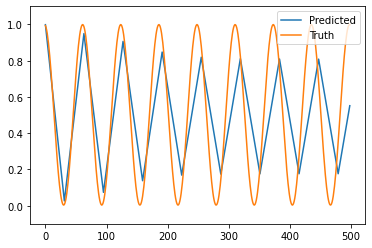

In [72]:
#====================================================================================
def plot_lowest_error(data, model):
    """
    Plot data at model, idx
    
    inputs:
        data: tensor of shape (n_points, n_timesteps, dim, dim)
        model: Resnet model to predict on 
    outputs:
        No returned values, but graph shown
    
    
    """
    data  = torch.flatten(data, 2,3)
    _, total_steps, _ = data.shape
    y_preds = model.uni_scale_forecast(torch.tensor(data[:,0,:]).float(), n_steps=total_steps-1)
    plt.plot(y_preds[0,:,0], label = "Predicted")
    plt.plot(data[0,1:,0], label = "Truth")
    plt.ylim([-.1, 1.1])
    plt.legend()
    plt.show()
#====================================================================================

    
plot_lowest_error(val_dict[str(current_size)], models[idx_lowest])

In [131]:
#====================================================================================
def find_error(data, model, truth_data, tol = 1e-5, criterion = torch.nn.MSELoss(reduction='none')):
    """
    Find error over the 4 squares 
    
    inputs:
        data: tensor of size (n_points, n_timesteps, dim, dim) to be predicted
        model: Resnet object to predict data on
        truth_data: tensor of size (n_points, n_timesteps, dim_larger, dim_larger) compared on 
        tol = 1e-5: tolerance level to mark points as resolved or not
        criterion = torch.nn.MSELoss(reduction='none')
        
    outputs:
        resolved: boolean whether complete area is resolved or not
        loss: array of floats for size (dim, dim) with mse of each square
        unresolved: array of booleans, whether that part is resolved or not. (0 unresolved, 1 resolved)
    """
    n_points, n_timesteps, dim, _ = data.shape
    data  = torch.flatten(data, 2,3)
    y_preds = model.uni_scale_forecast(torch.tensor(data[:,0,:]).float(), n_steps=n_timesteps-1).reshape(( n_points, n_timesteps-1, dim,dim))
    
    _,_, truth_dim, _ = truth_data.shape
    assert truth_dim >= dim
    
    loss = mse(y_preds, truth_data[:,1:])
    
    return loss.max() <= tol, loss, loss <= tol
#====================================================================================    
    
def mse(data1, data2):
    """
    Finds Mean Squared Error between data1 and data2
    
    inputs:
        data1: tensor of shape (n_points, n_timestep, dim1, dim1)
        data2: tensor of shape (n_points, n_timestep, dim2, dim2)
        
    output:
        mse: array of size (min_dim, min_dim) with mse 
    
    """
    #find bigger dim
    size1 = data1.shape[-1]
    size2 = data2.shape[-1]
    size_max = max(size1, size2)
    
    #grow to save sizes and find mse
    mse = np.mean((grow(data1, size_max) - grow(data2, size_max))**2, axis = (0, 1))
    return mse
#====================================================================================
    
def grow(data, dim_full=128):
    '''
    Grow tensor from any size to a bigger size
    inputs: 
        data: tensor to grow, size (n_points, n_timesteps, dim_small, dim_small)
        dim_full = 128: int of size to grow data to

    outputs:
        data_full: tensor size (n_points, n_timesteps, size_full, size_full)
    '''
    n_points, n_timesteps, dim_small, _ = data.shape 
    assert dim_full % dim_small == 0 #need small to be multiple of full

    divide = dim_full // dim_small

    data_full = np.zeros((n_points, n_timesteps, dim_full,dim_full))
    for i in range(dim_small):
        for j in range(dim_small):
            repeated = np.repeat(np.repeat(data[:,:,i,j].reshape(n_points,n_timesteps,1,1), divide, axis = 2), divide, axis = 3)
            data_full[:,:,i*divide:(i+1)*divide, j*divide:(j+1)*divide] = repeated
    return data_full
#====================================================================================


resolved, loss, unresolved = find_error(val_dict['1'], models[idx_lowest], val_dict['2'])
print(loss.shape)

(2, 2)


<ipython-input-131-a37956edb375>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = model.uni_scale_forecast(torch.tensor(data[:,0,:]).float(), n_steps=n_timesteps-1).reshape(( n_points, n_timesteps-1, dim,dim))
